# Data import and preparation

In [1]:
import pandas as pd
import numpy as np

# Convert a dataset into a windowed format
# For example:
# window = 2
# dataset =
# [
#  [1, 2, 3],
#  [2, 3, 4],
#  [5, 6, 7]
# ]
#
# Will result in:
# [
#  [0, 0, 0, 0, 0, 0, 1, 2, 3],
#  [0, 0, 0, 1, 2, 3, 2, 3, 4],
#  [1, 2, 3, 2, 3, 4, 5, 6, 7]
# ]
def prepare_dataset(dataset, window):
    windowed_data = []
    # TODO append the first "window" rows padded with 0s
    for i in range(len(dataset)-window-1):
        observation = dataset[i:(i+window),]
        windowed_data.append(observation)
    return np.array(windowed_data)

def load_prepared_dataset(path, window):
    # Read training data into memory
    data_raw = pd.read_csv(path)
    
    # Select training columns
    data_selected_raw = data_raw[[" LinAccX (g)"]].as_matrix()
    
    return data_raw, prepare_dataset(data_selected_raw, window)
    
# How long 
window = 20

# Load data used for training
data_train_raw, data_train = load_prepared_dataset('resources/normal.csv', window)
# Load data used for testing/validating
data_validate_raw, data_validate = load_prepared_dataset('resources/verify.csv', window)

# Number of columns = number of features * window
features = data_train.shape[1] / window
total_features = data_train.shape[1]

# Data visualization

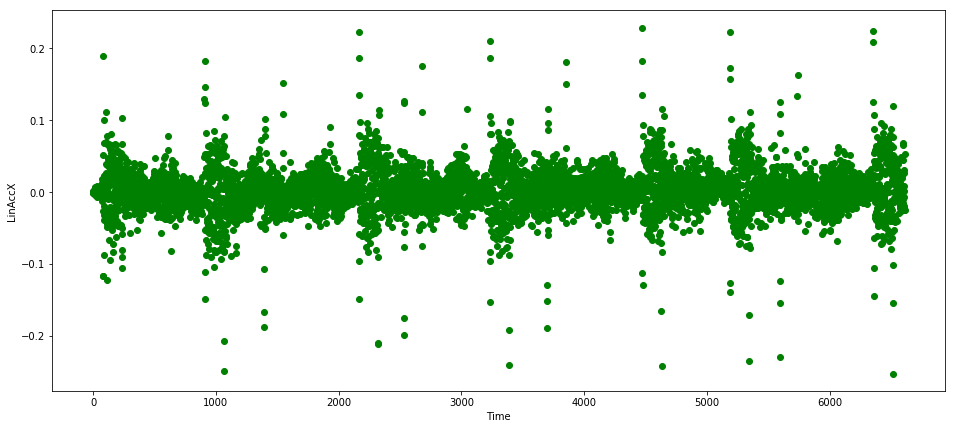

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(16, 7)

plt.plot(list(range(len(data_train_raw[" LinAccX (g)"]))), data_train_raw[" LinAccX (g)"], "go")
plt.ylabel('LinAccX')
plt.xlabel('Time')
plt.show()

# Multi layer perceptron

In [3]:
from __future__ import print_function
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

In [4]:
train_iter = mx.io.NDArrayIter(
    data={'data': data_train}, 
    label={'data': data_train},
    batch_size=64, shuffle=False, 
    last_batch_handle='pad')

In [5]:
data = mx.symbol.Variable('data')
fc1 = mx.symbol.FullyConnected(data, name='fc1', num_hidden=128)
act1 = mx.symbol.Activation(fc1, name='relu1', act_type='relu')
out = mx.symbol.FullyConnected(act1, name='fc2', num_hidden=total_features)
out_reshaped = mx.sym.Reshape(out, shape=(-1,total_features,1))
loss = mx.symbol.LinearRegressionOutput(data=out_reshaped, label=data)
model = mx.mod.Module(
    loss,
    context = mx.cpu(0), # use mx.gpu(0) on GPU enabled machines
    data_names=['data'],
    label_names=['data']
)

In [6]:
model.fit(train_iter,
          num_epoch = 100, 
          eval_metric='rmse')

In [7]:
def rmse(targets, predictions):
     return np.sqrt(np.mean((predictions-targets)**2))
    
predictions = model.predict(train_iter).asnumpy()
errors = list(map(lambda e: rmse(e[0], e[1]), zip(data_train, predictions)))
threshold =  np.mean(errors) + 3*np.std(errors)

In [8]:
test_iter = mx.io.NDArrayIter(
    data={'data': data_validate}, 
    label={'data': data_validate},
    batch_size=64, shuffle=False, 
    last_batch_handle='pad')

predictions = model.predict(test_iter).asnumpy()
errors = list(map(lambda e: rmse(e[0], e[1]), zip(data_validate, predictions)))
anomaly = list(map(lambda v: v > threshold, errors))
anomaly = list(map(lambda v: "red" if v else "green", anomaly))

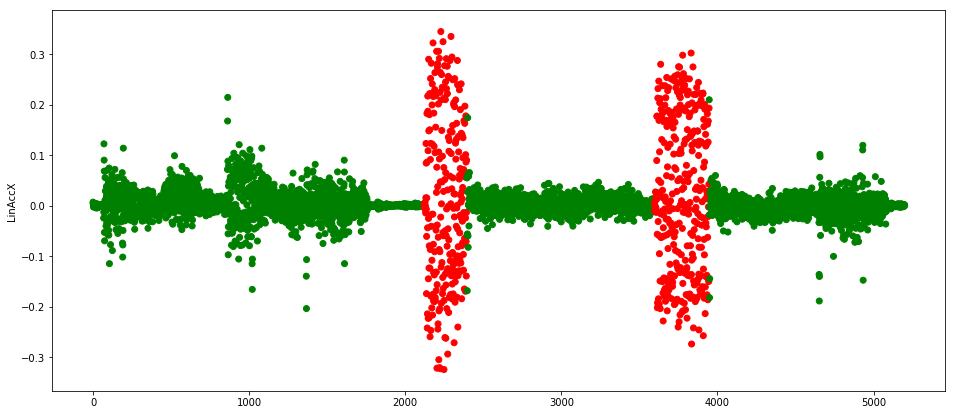

In [9]:
plt.scatter(list(range(len(data_validate_raw[" LinAccX (g)"]))), data_validate_raw[" LinAccX (g)"], c=anomaly)
plt.ylabel('LinAccX')
plt.show()

# Long-short term memory

In [ ]:
layer = mx.gluon.rnn.LSTM(features, 3)
layer.initialize()
output = layer(data_train)